# Navier Stokes using <img src=https://julialang.org/assets/infra/logo.svg width="80">

In this notebook, we will generate data for the Navier Stokes equation. We will use the same approach as in the paper, where we will generate data for the following equation:

$$
\begin{align*}
\partial_t w(x,t) + u(x,t) \cdot \nabla w(x,t) &= \nu \Delta w(x,t) + f(x)\\
\nabla \cdot u(x,t) &= 0\\
w(x,0) &= w_0(x)
\end{align*}
$$

## Environment Setup

In [2]:
using Pkg
Pkg.activate("env_julia")

  Activating project at `d:\Abel Santillan Rodriguez\Documents\Personal\Programacion\Projects\Fourier Neural Operator\env_julia`

## Libraries



In [310]:
Pkg.add("Plots")
Pkg.add("CUDA")
Pkg.add("FFTW")
Pkg.add("BenchmarkTools")


   Resolving package versions...


  No Changes to `D:\Abel Santillan Rodriguez\Documents\Personal\Programacion\Projects\Fourier Neural Operator\env_julia\Project.toml`
  No Changes to `D:\Abel Santillan Rodriguez\Documents\Personal\Programacion\Projects\Fourier Neural Operator\env_julia\Manifest.toml`


   Resolving package versions...

  No Changes to `D:\Abel Santillan Rodriguez\Documents\Personal\Programacion\Projects\Fourier Neural Operator\env_julia\Project.toml`
  No Changes to `D:\Abel Santillan Rodriguez\Documents\Personal\Programacion\Projects\Fourier Neural Operator\env_julia\Manifest.toml`

   Resolving package versions...


  No Changes to `D:\Abel Santillan Rodriguez\Documents\Personal\Programacion\Projects\Fourier Neural Operator\env_julia\Project.toml`
  No Changes to `D:\Abel Santillan Rodriguez\Documents\Personal\Programacion\Projects\Fourier Neural Operator\env_julia\Manifest.toml`

   Resolving package versions...

   Installed BenchmarkTools ─ v1.3.2


    Updating `D:\Abel Santillan Rodriguez\Documents\Personal\Programacion\Projects\Fourier Neural Operator\env_julia\Project.toml`
  [6e4b80f9] + BenchmarkTools v1.3.2
    Updating `D:\Abel Santillan Rodriguez\Documents\Personal\Programacion\Projects\Fourier Neural Operator\env_julia\Manifest.toml`


  [6e4b80f9] + BenchmarkTools v1.3.2
  [9abbd945] + Profile


Precompiling project...

  ✓ BenchmarkTools
  1 dependency successfully precompiled in 5 seconds. 203 already precompiled.


In [3]:
using BenchmarkTools
using CUDA
using FFTW
using Plots

## Functions

### Function to generate random initial conditions

In [6]:
mutable struct GaussianRF
    dim::Int32                      # Dimension of the random field (1, 2, or 3)
    size::AbstractArray{Int32}      # Size of the random field
    alpha::Float32                  # Hurst parameter
    tau::Float32                    # Correlation length
    sigma::Float32                  # Standard deviation
    boundary::String                # Boundary conditions (periodic or zero)
    device::String                # Device to store the random field (GPU or CPU)
    sqrt_eig::AbstractArray{Float32}      # Square root of the eigenvalues of the covariance matrix

    # Constructor with all the parameters
    function GaussianRF(dim::Int64, size::Int64, alpha::Real, tau::Real, sigma::Real, boundary::String, device::String)
        x = new(dim, [size], alpha, tau, sigma, boundary, device, Array{Float32}(undef, size, size, size))
        init_field(x)
        return x
    end
    
    # Constructor with default parameters
    function GaussianRF(dim::Int64, size::Int64)
        # Detect device
        if CUDA.functional()
            device = "GPU"
        else
            device = "CPU"
        end
        x = new(dim, [size], 2, 3, 0, "periodic", device, Array{Float32}(undef, size, size, size))
        init_field(x)
        return x
    end
end


# Initialize the random field
function init_field(x::GaussianRF)
    if x.sigma == 0
        x.sigma = x.tau^(0.5*(2*x.alpha - x.dim))
    end
    
    k_max = x.size[1]//2


    if x.dim == 1
        k = [collect(Float64, 0:1:k_max); collect(Float64, -k_max:1:0)]
        x.sqrt_eig = x.size[1] * sqrt(2.0) * x.sigma * ((4*pi^2*k.^2) .+ x.tau^2).^(0.5*(-x.alpha))
        CUDA.@allowscalar x.sqrt_eig[1] = 0

    elseif x.dim == 2
        k = [collect(Float64, 0:1:k_max-1); collect(Float64, -k_max:1:-1)]
        k = Matrix(repeat(k, 1, x.size[1]))
        ky = k
        kx = k'

        x.sqrt_eig = x.size[1].^2 * sqrt(2.0) * x.sigma * ((4*pi^2*(kx.^2 + ky.^2)) .+ x.tau^2).^(0.5*(-x.alpha))
        CUDA.@allowscalar x.sqrt_eig[1, 1] = 0
    elseif x.dim == 3
        k = [collect(Float64, 0:1:k_max-1); collect(Float64, -k_max:1:-1)]
        k = repeat(k, 1, x.size[1], x.size[1])
        ky = k
        kx = PermutedDimsArray(k, (2, 1, 3))
        kz = PermutedDimsArray(k, (3, 2, 1))

        x.sqrt_eig = x.size[1].^3 * sqrt(2.0) * x.sigma * ((4*pi^2*(kx.^2 + ky.^2 + kz.^2)) .+ x.tau^2).^(0.5*(-x.alpha))
        CUDA.@allowscalar x.sqrt_eig[1, 1, 1] = 0
    end

    # Set new dimensions
    for i in 1:x.dim-1
        push!(x.size, x.size[1])
    end
end

# Function to get sample
function sample(x::GaussianRF, N::Int64)
    dimension = Tuple(Int(x) for x in x.size)
    coeff = CuArray{ComplexF64}(undef, dimension)
    coeff = randn(dimension) + im*randn(dimension)
    coeff = Array(x.sqrt_eig) .* coeff

    # torch.fft.ifftn(coeff, dim=list(range(-1, -self.dim - 1, -1))).real
    result = real(FFTW.ifft!(coeff))
    result = PermutedDimsArray(result, collect(1:x.dim))
    return result
end


sample (generic function with 1 method)

In [8]:
x = GaussianRF(2, 32, 2, 3, 1, "periodic", "GPU")

GaussianRF(2, Int32[32, 32], 2.0f0, 3.0f0, 1.0f0, "periodic", "GPU", Float32[0.0 29.872152 … 8.67607 29.872152; 29.872152 16.464378 … 7.0165224 16.464378; … ; 8.67607 7.0165224 … 4.458229 7.0165224; 29.872152 16.464378 … 7.0165224 16.464378])

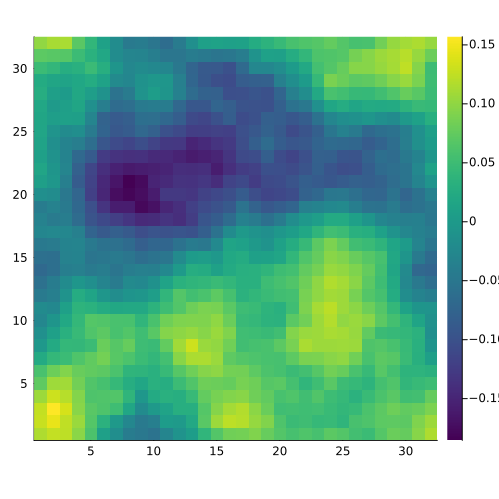

In [23]:
# Measure the time to sample
w0 =  sample(x, 1)

# Plot the sample as colormap
heatmap(w0, aspect_ratio=:equal, color=:viridis, cbar=true, size=(500, 500))

### Function to solve the Navier Stokes equation

In [319]:
function solve_navier_stokes(w0::AbstractArray{Float64}, f::AbstractArray{Float64}, v::Float64, T::Float64, dt::Float64 = 1e-4, record_steps::Int64 = 1)

    # Grid size (it must be a power of 2)
    N = size(w0)[1]

    # Max wavenumber
    k_max = floor(Int64, N/2)

    # Total number of steps
    n_steps = ceil(Int64, T/dt)

    # Initial vortex field in Fourier Space
    w_h = FFTW.rfft(w0)

    # Forcing field in Fourier Space
    f_h = FFTW.rfft(f)

    # If the same forcing for the whole batch
    if size(f_h)[1] < size(w_h)[1]
        f_h = repeat(f_h, outer = [size(w_h)[1]//size(f_h)[1]])
    end

    # Save the solution every record_steps steps
    record_time = floor(Int64, n_steps/record_steps)

    # Wave numbers in y-direction
    k_y = [collect(Float64, 0:1:k_max-1); collect(Float64, -k_max:1:-1)]
    k_y = Matrix(repeat(k_y, 1, N))

    # Wave numbers in x-direction
    k_x = [collect(Float64, 0:1:k_max-1); collect(Float64, -k_max:1:-1)]
    k_x = Matrix(repeat(k_x, N, 1))

    # Remove redundant modes
    k_x = k_x[:, 1:k_max+1]
    k_y = k_y[1:k_max+1, :]

    # Negative of the Laplacian in Fourier Space
    lap = 4*pi^2 * (k_x.^2 + k_y.^2)
    lap[1, 1] = 1.0

    # Dealiasing mask
    dealias = (abs.(k_y) .<= (2.0/3.0)*k_max) .* (abs.(k_x) .<= (2.0/3.0)*k_max)
    dealias = PermutedDimsArray(dealias, (3, 1, 2))

    # Save the solution and time
    dimension =  Tuple(Int(x) for x in size(w0))
    sol = zeros(Float64, dimension..., record_time)
    solt_t = zeros(Float64, record_time)

    # Record counter
    c = 0

    # Physical Time
    t = 0.0

    # Loop
    for j in 1:n_steps

        # Stream function in Fourier Space
        psi_h = w_h ./ lap

        # Velocity field in x-direction = psi_y
        q = 2. * pi * k_y .* psi_h * im
        q = real(FFTW.ifft!(q))

        # Velocity field in y-direction = -psi_x
        v = -2. * pi * k_x .* psi_h * im
        v = real(FFTW.ifft!(v))
    
end

navier_stokes_2d (generic function with 3 methods)

## Generate data

In [320]:
# Resolution
s = 16

# Number of solutions to generate
N = 1

# Set up 2D GRF with covariance parameters
GRF = GaussianRF(2, s)

# Time grid
t = range(0, stop=1, length=s+1)
t = t[1:end-1]

# Forcing function: 0.1 * (sin(2π(x+y)) + cos(2π(x+y)))
X = repeat(t, 1, s)
Y = repeat(transpose(t), s, 1)
f = 0.1 * (sin.(2 * π * (X + Y)) + cos.(2 * π * (X + Y)))

# Number of snapshots from solution
record_steps = 200

# Inputs
a = zeros(N, s, s)
# Solutions
u = zeros(N, s, s, record_steps)

# Solve equations in batches (order of magnitude speed-up)

# Batch size
bsize = 1

c = 1
t0 = time()
for j in 1:N ÷ bsize
    # Sample random fields
    w0 = sample(GRF, bsize)

    # Solve NS
    sol, sol_t = navier_stokes_2d(w0, f, 1e-3, 50.0, 1e-4, record_steps)

    a[c:c+bsize-1, :, :] = w0
    u[c:c+bsize-1, :, :, :] = sol

    c += bsize
    t1 = time()
    println(j, ", ", c, ", ", t1 - t0)
end

# Save data to a .mat file
# Replace with your preferred method for saving data in Julia
# For example, using the MAT.jl package:
# using MAT

# matwrite("ns_data.mat", Dict("a" => a, "u" => u, "t" => sol_t))


DimensionMismatch: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(16), Base.OneTo(9)), b has dims (Base.OneTo(17), Base.OneTo(9)), mismatch at 1